<a href="https://colab.research.google.com/github/hansong0219/Advanced-DeepLearning-Study/blob/master/UNET/UNET_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import sys
from tensorflow.keras.layers import Input, Dropout, Concatenate
from tensorflow.keras.layers import Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def down_sample(layer_inputs,filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    d = Conv2D(filters, size, strides=2,padding='same', kernel_initializer=initializer, use_bias=False)(layer_inputs)
    if apply_batchnorm:
        d = BatchNormalization()(d)
    
    d = LeakyReLU(alpha=0.2)(d)
    return d

def up_sample(layer_inputs, skip_input,filters, size, dropout_rate=0):
    initializer = tf.random_normal_initializer(0.,0.02)    
    u = Conv2DTranspose(filters, size, strides=2,padding='same', kernel_initializer=initializer,use_bias=False)(layer_inputs)
    if dropout_rate:
        u = Dropout(dropout_rate)(u)
    
    u = tf.keras.layers.ReLU()(u)
    u = Concatenate()([u, skip_input])
    return u

In [ ]:
def Build_UNET():
    input_shape = (256,256,3)
    output_channel = 3
    inputs = Input(shape=input_shape,name="inputs")
    
    d1 = down_sample(inputs, 64, 4, apply_batchnorm=False) #(128,128,3)
    d2 = down_sample(d1, 128, 4) #(64,64,128)
    d3 = down_sample(d2, 256, 4)
    d4 = down_sample(d3, 512, 4)
    d5 = down_sample(d4, 512, 4)
    d6 = down_sample(d5, 512, 4)
    d7 = down_sample(d6, 512, 4)
    d8 = down_sample(d7, 512, 4)
    
    u7 = up_sample(d8, d7, 512, 4, dropout_rate = 0.5)
    u6 = up_sample(u7, d6, 512, 4, dropout_rate = 0.5)
    u5 = up_sample(u6, d5, 512, 4, dropout_rate = 0.5)
    u4 = up_sample(u5, d4, 512, 4)
    u3 = up_sample(u4, d3, 256, 4)
    u2 = up_sample(u3, d2, 128, 4)
    u1 = up_sample(u2, d1, 64, 4)
    
    initializer = tf.random_normal_initializer(0.,0.02)
    outputs = Conv2DTranspose(output_channel,
                              kernel_size=4, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=initializer, 
                              activation='tanh')(u1)
    
    return Model(inputs, outputs)

In [ ]:
unet = Build_UNET()

In [ ]:
optimizer = Adam(1e-4, beta_1=0.5)
unet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3072        inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131072      leaky_re_lu[0][0]                
_______________________________________________________________________________________

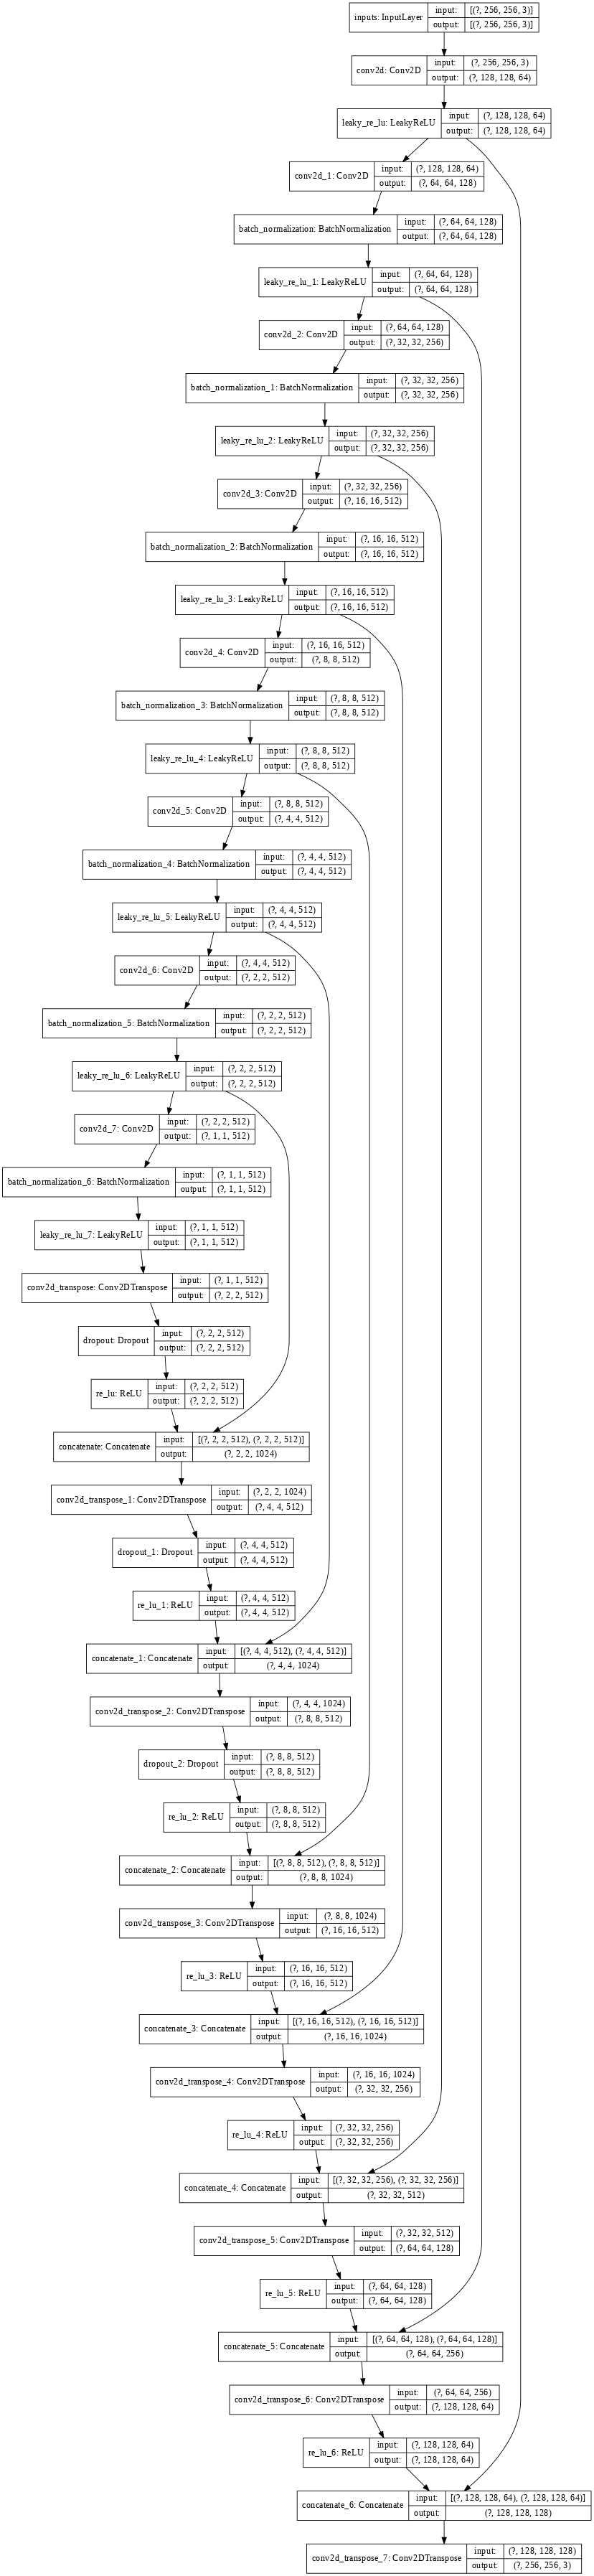

In [ ]:
plot_model(unet, show_shapes=True, dpi=64)

In [ ]:
loss=BinaryCrossentropy(from_logits=True)
optimizer = Adam(1e-4, beta_1=0.5)
unet.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])